In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from geopy.distance import great_circle
from shapely.geometry import Point
import numpy as np

In [2]:
hexagono500_centoide = r"D:\MASTER TIG\SIG\Practica1_localizacion_equipamientos\capas_modelo\hexagonos_200_pob_centroide.shp"
centros_educativos = r"D:\MASTER TIG\SIG\Practica1_localizacion_equipamientos\datos\educapubli_alcala.shp"
hexagono500 = r"D:\MASTER TIG\SIG\Practica1_localizacion_equipamientos\hexagonos200_pob.shp"

In [3]:
df_hexagono_500 = gpd.read_file(hexagono500_centoide)
df_hexagono = gpd.read_file(hexagono500)
df_centros = gpd.read_file(centros_educativos)

In [4]:
#df_centros = df_centros[df_centros["DS_LARGO"] == 'Instituto de Educación Secundaria']

In [5]:
# Usar .apply() con una función lambda para asignar valores a la nueva columna 'capacidad'
df_centros['capacidad'] = df_centros['DS_LARGO'].apply(lambda x: 800 if x == 'Colegio Infantil, Primaria y Secundaria' 
                                            else 400 if x == 'Colegio Infantil y Primaria' 
                                            else 540 if x == 'Instituto de Educación Secundaria' 
                                            else 250 if x == 'Escuela de Educación Infantil' 
                                            else 0) 

In [6]:
df_centros["DS_LARGO"].unique()

array(['Colegio Infantil y Primaria', 'Instituto de Educación Secundaria',
       'Centro de Educación Especial', 'Escuela de Educación Artística',
       'Escuela Oficial Idiomas', 'Escuela de Educación Infantil',
       'Centro Educación de Adultos'], dtype=object)

In [7]:
# Tipos de centros a eliminar
centros_a_eliminar = ['Escuela Oficial Idiomas', 'Centro Educación de Adultos', 'Escuela de Educación Artística']

# Filtrar el DataFrame para excluir los tipos de centros especificados
df_centros = df_centros[~df_centros['DS_LARGO'].isin(centros_a_eliminar)]

In [8]:
df_centros["DS_LARGO"].unique()

array(['Colegio Infantil y Primaria', 'Instituto de Educación Secundaria',
       'Centro de Educación Especial', 'Escuela de Educación Infantil'],
      dtype=object)

In [9]:
place_name = "Alcala de Henares, España" 
network_type = 'walk'
G = ox.graph_from_place(place_name, network_type=network_type)

In [10]:
# Asumiendo que G es tu grafo de OSMnx
G_proj = ox.project_graph(G)

# Convertir el grafo en GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G_proj)

# Cambiar el CRS de los GeoDataFrames
gdf_nodes = gdf_nodes.to_crs("EPSG:25830")
gdf_edges = gdf_edges.to_crs("EPSG:25830")
# Reconstruir el grafo desde los GeoDataFrames
G_proj = ox.graph_from_gdfs(gdf_nodes, gdf_edges)

C:\Users\Jason\AppData\Local\Temp\ipykernel_24840\3357375057.py:11: UserWarning: discarding the gdf_nodes geometry column, though its values differ from the coordinates in the x and y columns
  G_proj = ox.graph_from_gdfs(gdf_nodes, gdf_edges)


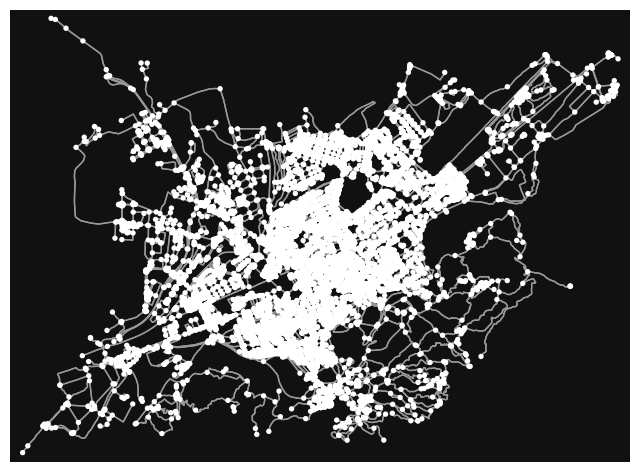

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [11]:
ox.plot_graph(G_proj)

In [12]:
# Asegúrate de que tus GeoDataFrames estén en el mismo CRS que la red de calles
df_hexagono_500 = df_hexagono_500.to_crs("EPSG:25830")
# Aquí suponemos que `houses_gdf` es tu GeoDataFrame de residencias
df_centros = df_centros.to_crs("EPSG:25830")

In [13]:
df_hexagono_500['nearest_node'] = df_hexagono_500.geometry.apply(lambda x: ox.distance.nearest_nodes(G_proj, X=x.x, Y=x.y))
df_centros['nearest_node'] = df_centros.geometry.apply(lambda x: ox.distance.nearest_nodes(G_proj, X=x.x, Y=x.y))

In [14]:
walk_speed_m_per_s = 1.4

In [15]:
# Inicializa un DataFrame vacío para almacenar los resultados
columnas = ['index_punto_pob', 'index_col', 'tiempo_viaje']
df_resultados = pd.DataFrame(columns=columnas)

# Accesibilidad General

In [16]:
for index_punto_pob, punto_pob in df_hexagono_500.iterrows():
    print("Calculo de tiempo de viaje para el hexagono {0}".format(index_punto_pob))
    for index_col, punto_col in df_centros.iterrows():
        try:
            tiempo_viaje = (nx.shortest_path_length(G_proj, punto_pob.nearest_node, punto_col.nearest_node, weight='length'))/walk_speed_m_per_s
            resultado_df = pd.DataFrame([{
                'index_punto_pob': index_punto_pob,
                'index_col': index_col,
                'tiempo_viaje': tiempo_viaje
            }])
            
            # Concatena 'resultado_df' con 'df_resultados'
            df_resultados = pd.concat([df_resultados, resultado_df], ignore_index=True)
        except nx.NetworkXNoPath:
            print("Error al momento de hace el tiempo de viaje")
            continue

Calculo de tiempo de viaje para el hexagono 0


C:\Users\Jason\AppData\Local\Temp\ipykernel_24840\1157754677.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados = pd.concat([df_resultados, resultado_df], ignore_index=True)


Calculo de tiempo de viaje para el hexagono 1
Calculo de tiempo de viaje para el hexagono 2
Calculo de tiempo de viaje para el hexagono 3
Calculo de tiempo de viaje para el hexagono 4
Calculo de tiempo de viaje para el hexagono 5
Calculo de tiempo de viaje para el hexagono 6
Calculo de tiempo de viaje para el hexagono 7
Calculo de tiempo de viaje para el hexagono 8
Calculo de tiempo de viaje para el hexagono 9
Calculo de tiempo de viaje para el hexagono 10
Calculo de tiempo de viaje para el hexagono 11
Calculo de tiempo de viaje para el hexagono 12
Calculo de tiempo de viaje para el hexagono 13
Calculo de tiempo de viaje para el hexagono 14
Calculo de tiempo de viaje para el hexagono 15
Calculo de tiempo de viaje para el hexagono 16
Calculo de tiempo de viaje para el hexagono 17
Calculo de tiempo de viaje para el hexagono 18
Calculo de tiempo de viaje para el hexagono 19
Calculo de tiempo de viaje para el hexagono 20
Calculo de tiempo de viaje para el hexagono 21
Calculo de tiempo de v

In [17]:
df_resultados.to_csv("Distancias.csv")

In [ ]:
# df_resultados = pd.read_csv("Distancias.csv")

In [18]:
df_resultados.head(1)

,index_punto_pob,index_col,tiempo_viaje
0,0,0,1142.709286


In [19]:
df_hexagono_500.head(1)

,id,left,top,right,bottom,pobxparcel,geometry,nearest_node
0,2108.0,468468.639588,4.481286e+06,468699.579696,4.481086e+06,204.968593,POINT (468584.110 4481185.734),7126654298


In [20]:
import numpy as np

def funcion_decaimiento(tiempo_viaje, tiempo_max):
    # Asumiendo que tiempo_max es el máximo tiempo de viaje en tu análisis (por ejemplo, 45*60 para 45 minutos)
    return np.exp(-tiempo_viaje / tiempo_max)


# Aplicación de la Función de Decaimiento en la Accesibilidad de la Oferta (Colegios) a 15 minutos

In [21]:
df_centros['accesibilidad_15min'] = 0

for index_colegio, colegio in df_centros.iterrows():
    accesibilidad_colegio = 0
    suma_ponderada_poblacion = 0 
    df_colegio = df_resultados[df_resultados['index_col'] == index_colegio]
    
    for _, row in df_colegio.iterrows():
        # Obtener la población del punto de demanda
        poblacion_accesible = df_hexagono_500.loc[row['index_punto_pob'], 'pobxparcel']
        
        # Aplicar la función de decaimiento al tiempo de viaje
        factor_decaimiento = funcion_decaimiento(row['tiempo_viaje'], 900)  # Usando 15 minutos como tiempo máximo
        # print(row['tiempo_viaje'])
        suma_ponderada_poblacion += poblacion_accesible * factor_decaimiento
        # Ajustar la población por el factor de decaimiento
        #accesibilidad_colegio += poblacion_accesible * factor_decaimiento
    # Calcular la accesibilidad del colegio como capacidad / suma ponderada de población
    if suma_ponderada_poblacion > 0:  # Para evitar la división por cero
        df_centros.at[index_colegio, 'accesibilidad_15min'] = colegio['capacidad'] / suma_ponderada_poblacion
    else:
        df_centros.at[index_colegio, 'accesibilidad_15min'] = 0
    #df_centros.at[index_colegio, 'accesibilidad'] = accesibilidad_colegio


C:\Users\Jason\AppData\Local\Temp\ipykernel_24840\2145344851.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.007458814438543725' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_centros.at[index_colegio, 'accesibilidad_15min'] = colegio['capacidad'] / suma_ponderada_poblacion


In [22]:
resumen_estadistico = df_centros['accesibilidad_15min'].describe()
print(resumen_estadistico)

count    60.000000
mean      0.010052
std       0.006854
min       0.000000
25%       0.006397
50%       0.008609
75%       0.012622
max       0.047914
Name: accesibilidad_15min, dtype: float64


# Aplicación de la Función de Decaimiento en la Accesibilidad de la Demanda (Puntos de Población) a 15 min 

In [23]:
df_hexagono_500['accesibilidad_15min'] = 0

for index_punto, punto in df_hexagono_500.iterrows():
    accesibilidad_punto = 0
    suma_ponderada_poblacion = 0 
    df_punto = df_resultados[df_resultados['index_punto_pob'] == index_punto]
    poblacion_accesible = df_hexagono_500.loc[row['index_punto_pob'], 'pobxparcel']
    for _, row in df_punto.iterrows():
        # Obtener la accesibilidad del colegio
        accesibilidad_colegio = df_centros.loc[row['index_col'], 'accesibilidad_15min']
        
        # Aplicar la función de decaimiento al tiempo de viaje
        factor_decaimiento = funcion_decaimiento(row['tiempo_viaje'], 900)  # Usando 45 minutos como tiempo máximo
        accesibilidad_punto += accesibilidad_colegio * factor_decaimiento
        # Ajustar la accesibilidad del colegio por el factor de decaimiento
    df_hexagono_500.at[index_punto, 'accesibilidad_15min'] = accesibilidad_punto

C:\Users\Jason\AppData\Local\Temp\ipykernel_24840\2783378487.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1431796038191288' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_hexagono_500.at[index_punto, 'accesibilidad_15min'] = accesibilidad_punto


In [24]:
df_hexagono_500.head(2)

,id,left,top,right,bottom,pobxparcel,geometry,nearest_node,accesibilidad_15min
0,2108.0,468468.639588,4.481286e+06,468699.579696,4.481086e+06,204.968593,POINT (468584.110 4481185.734),7126654298,0.143180
1,2164.0,468641.844669,4.481386e+06,468872.784776,4.481186e+06,297.323697,POINT (468757.315 4481285.734),7096895724,0.147772


In [25]:
df_hexagono.head(2)

,id,left,top,right,bottom,pobxparcel,geometry
0,2108.0,468468.639588,4.481286e+06,468699.579696,4.481086e+06,204.968593,"POLYGON ((468468.640 4481185.734, 468526.375 4..."
1,2164.0,468641.844669,4.481386e+06,468872.784776,4.481186e+06,297.323697,"POLYGON ((468641.845 4481285.734, 468699.580 4..."


In [26]:
# Hacer merge de los DataFrames en base a la columna 'id'
df_hexagono_final = df_hexagono.merge(df_hexagono_500[['id', 'accesibilidad_15min']], on='id', how='left')


In [27]:
df_hexagono_final.to_file("df_hexagono_final.shp")

C:\Users\Jason\AppData\Local\Temp\ipykernel_24840\3330190813.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df_hexagono_final.to_file("df_hexagono_final.shp")


In [28]:
import matplotlib.pyplot as plt

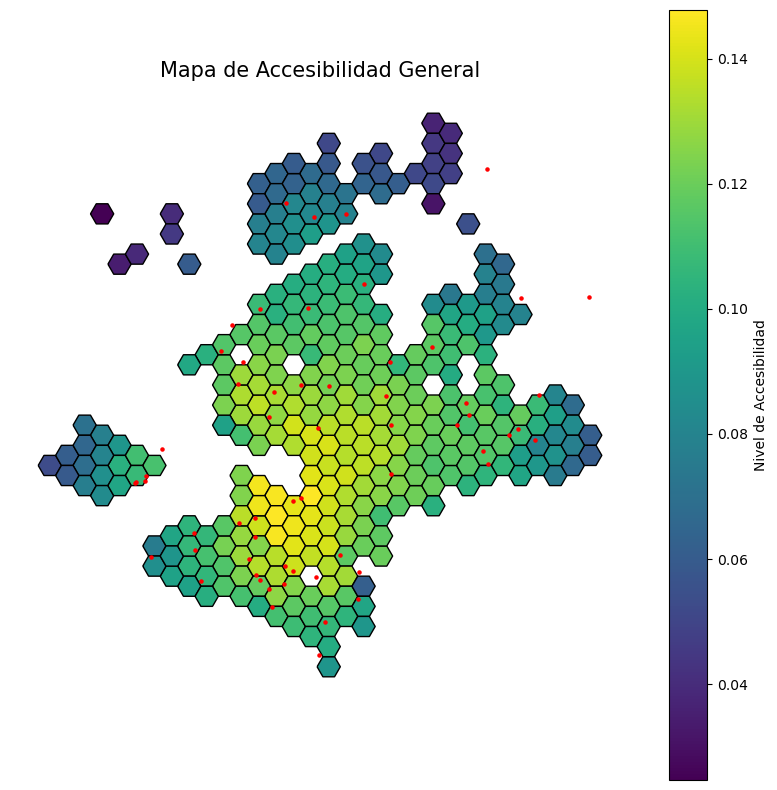

In [29]:
# Configurar la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 10))

# Graficar el GeoDataFrame, clasificando por 'accesibilidad'
df_hexagono_final.plot(column='accesibilidad_15min', ax=ax, legend=True,
                       cmap='viridis', edgecolor='k', legend_kwds={'label': "Nivel de Accesibilidad"})

df_centros.plot(ax=ax, marker='o', color='red', markersize=5)
# Añadir títulos y etiquetas
ax.set_title('Mapa de Accesibilidad General', fontsize=15)
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)

# Omitir los ejes para un mapa más limpio
ax.set_axis_off()

# Mostrar el mapa
plt.show()


In [ ]:
import osmnx as ox
import matplotlib.pyplot as plt

# Configurar la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 10))

# Graficar el GeoDataFrame de hexágonos, clasificando por 'accesibilidad'
df_hexagono_final.plot(column='accesibilidad', ax=ax, legend=True,
                       cmap='viridis', edgecolor='k', legend_kwds={'label': "Nivel de Accesibilidad"})

# Graficar los centros en el mismo eje
df_centros.plot(ax=ax, marker='o', color='red', markersize=5)

# Graficar la red de calles en el mismo eje
ox.plot_graph(G_proj, ax=ax, node_size=0, edge_color="gray", edge_linewidth=0.5, bgcolor="none", show=False, close=False)

# Añadir títulos y etiquetas
ax.set_title('Mapa de Accesibilidad', fontsize=15)
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)

# Omitir los ejes para un mapa más limpio
ax.set_axis_off()

# Mostrar el mapa
plt.show()


# Aplicación de la Función de Decaimiento en la Accesibilidad de la Demanda (Puntos de Población) a 30 min 

In [41]:
df_centros['accesibilidad_30min'] = 0

for index_colegio, colegio in df_centros.iterrows():
    accesibilidad_colegio = 0
    suma_ponderada_poblacion = 0 
    df_colegio = df_resultados[df_resultados['index_col'] == index_colegio]
    
    for _, row in df_colegio.iterrows():
        # Obtener la población del punto de demanda
        poblacion_accesible = df_hexagono_500.loc[row['index_punto_pob'], 'pobxparcel']
        
        # Aplicar la función de decaimiento al tiempo de viaje
        factor_decaimiento = funcion_decaimiento(row['tiempo_viaje'], 1800)  # Usando 15 minutos como tiempo máximo
        # print(row['tiempo_viaje'])
        suma_ponderada_poblacion += poblacion_accesible * factor_decaimiento
        # Ajustar la población por el factor de decaimiento
        #accesibilidad_colegio += poblacion_accesible * factor_decaimiento
    # Calcular la accesibilidad del colegio como capacidad / suma ponderada de población
    if suma_ponderada_poblacion > 0:  # Para evitar la división por cero
        df_centros.at[index_colegio, 'accesibilidad_30min'] = colegio['capacidad'] / suma_ponderada_poblacion
    else:
        df_centros.at[index_colegio, 'accesibilidad_30min'] = 0
    #df_centros.at[index_colegio, 'accesibilidad'] = accesibilidad_colegio

C:\Users\Jason\AppData\Local\Temp\ipykernel_24840\3712289742.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.004096144844153113' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_centros.at[index_colegio, 'accesibilidad_30min'] = colegio['capacidad'] / suma_ponderada_poblacion


# Aplicación de la Función de Decaimiento en la Accesibilidad de la Demanda (Puntos de Población) a 30 min 

In [42]:
df_hexagono_500['accesibilidad_30min'] = 0

for index_punto, punto in df_hexagono_500.iterrows():
    accesibilidad_punto = 0
    suma_ponderada_poblacion = 0 
    df_punto = df_resultados[df_resultados['index_punto_pob'] == index_punto]
    poblacion_accesible = df_hexagono_500.loc[row['index_punto_pob'], 'pobxparcel']
    for _, row in df_punto.iterrows():
        # Obtener la accesibilidad del colegio
        accesibilidad_colegio = df_centros.loc[row['index_col'], 'accesibilidad_30min']
        
        # Aplicar la función de decaimiento al tiempo de viaje
        factor_decaimiento = funcion_decaimiento(row['tiempo_viaje'], 1800)  # Usando 45 minutos como tiempo máximo
        accesibilidad_punto += accesibilidad_colegio * factor_decaimiento
        # Ajustar la accesibilidad del colegio por el factor de decaimiento
    df_hexagono_500.at[index_punto, 'accesibilidad_30min'] = accesibilidad_punto

C:\Users\Jason\AppData\Local\Temp\ipykernel_24840\1946288390.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13421924447694733' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_hexagono_500.at[index_punto, 'accesibilidad_30min'] = accesibilidad_punto


In [43]:
df_hexagono_final = df_hexagono.merge(df_hexagono_500[['id', 'accesibilidad_15min','accesibilidad_30min']], on='id', how='left')


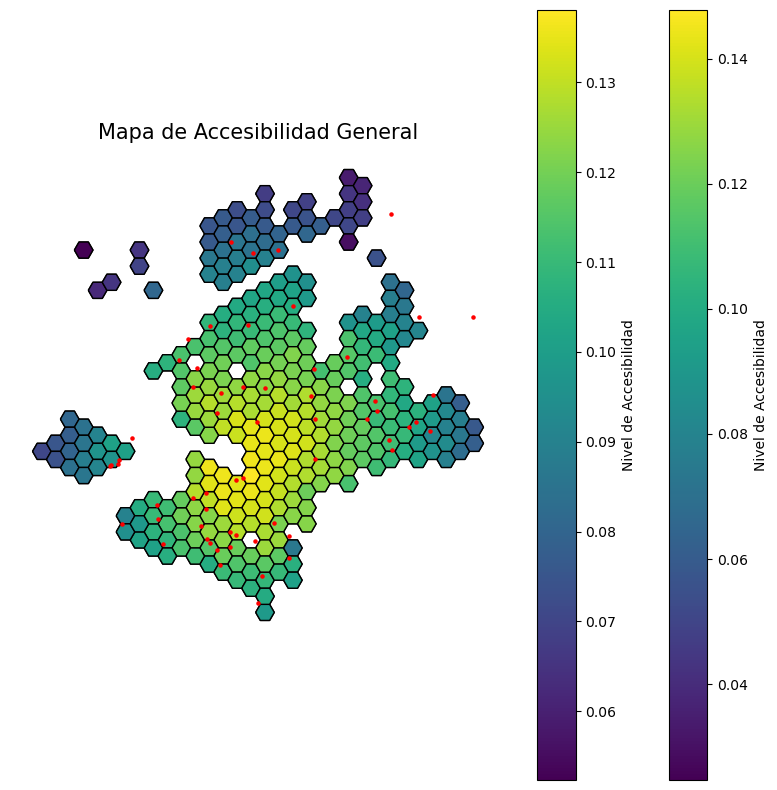

In [44]:
# Configurar la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 10))

# Graficar el GeoDataFrame, clasificando por 'accesibilidad'
df_hexagono_final.plot(column='accesibilidad_15min', ax=ax, legend=True,
                       cmap='viridis', edgecolor='k', legend_kwds={'label': "Nivel de Accesibilidad"})
df_hexagono_final.plot(column='accesibilidad_30min', ax=ax, legend=True,
                       cmap='viridis', edgecolor='k', legend_kwds={'label': "Nivel de Accesibilidad"})

df_centros.plot(ax=ax, marker='o', color='red', markersize=5)
# Añadir títulos y etiquetas
ax.set_title('Mapa de Accesibilidad General', fontsize=15)
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)

# Omitir los ejes para un mapa más limpio
ax.set_axis_off()

# Mostrar el mapa
plt.show()

In [45]:
df_hexagono_final.to_file("df_hexagono_final.shp")

C:\Users\Jason\AppData\Local\Temp\ipykernel_24840\3330190813.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df_hexagono_final.to_file("df_hexagono_final.shp")


In [48]:
df_centros.head(5)

,CODIGO,CLAVE,DIRECCION,CMUN,DESCR,UTM_X,UTM_Y,BUSCA,DS_ABREV,DS_LARGO,ETIQUETA,URL,geometry,capacidad,nearest_node,accesibilidad_15min,accesibilidad_30min
0,28000054,CEIP,"Calle San Ignacio de Loyola, 13",005,Antonio de Nebrija,468386,4482313,Colegio Infantil y Primaria CEIP Antonio de Ne...,CP INF-PRI,Colegio Infantil y Primaria,CEIP Antonio de Nebrija,https://gestiona.madrid.org/wpad_pub/run/j/Mos...,POINT (468386.000 4482313.000),400,259719695,0.007459,0.004096
1,28000066,CEIP,"Calle San Juan, 2",005,Cardenal Cisneros,468658,4481259,Colegio Infantil y Primaria CEIP Cardenal Cisn...,CP INF-PRI,Colegio Infantil y Primaria,CEIP Cardenal Cisneros,https://gestiona.madrid.org/wpad_pub/run/j/Mos...,POINT (468658.000 4481259.000),400,5687847305,0.006315,0.003698
2,28000078,CEIP,"Calle Giner de los Ríos, 5",005,Cervantes,469552,4481496,Colegio Infantil y Primaria CEIP Cervantes. Ca...,CP INF-PRI,Colegio Infantil y Primaria,CEIP Cervantes,https://gestiona.madrid.org/wpad_pub/run/j/Mos...,POINT (469552.000 4481496.000),400,2549112800,0.006424,0.003776
3,28000081,CEIP,"Calle Infantado, 2",005,Daoiz y Velarde,468826,4481956,Colegio Infantil y Primaria CEIP Daoiz y Velar...,CP INF-PRI,Colegio Infantil y Primaria,CEIP Daoiz y Velarde,https://gestiona.madrid.org/wpad_pub/run/j/Mos...,POINT (468826.000 4481956.000),400,11046869533,0.006216,0.003676
4,28037892,CEPA,"Calle San Vidal, 6",005,Don Juan I,468252,4480451,Colegio Infantil y Primaria CEPA Don Juan I. C...,CEPA,Colegio Infantil y Primaria,CEIP Reyes Católicos,https://gestiona.madrid.org/wpad_pub/run/j/Mos...,POINT (468251.934 4480450.642),400,2850150913,0.007634,0.004303


In [47]:
df_hexagono_final.head(5)

,id,left,top,right,bottom,pobxparcel,geometry,accesibilidad_15min,accesibilidad_30min
0,2108.0,468468.639588,4.481286e+06,468699.579696,4.481086e+06,204.968593,"POLYGON ((468468.640 4481185.734, 468526.375 4...",0.143180,0.134219
1,2164.0,468641.844669,4.481386e+06,468872.784776,4.481186e+06,297.323697,"POLYGON ((468641.845 4481285.734, 468699.580 4...",0.147772,0.138060
2,2165.0,468641.844669,4.481186e+06,468872.784776,4.480986e+06,335.871067,"POLYGON ((468641.845 4481085.734, 468699.580 4...",0.142804,0.135414
3,2166.0,468641.844669,4.480986e+06,468872.784776,4.480786e+06,737.003226,"POLYGON ((468641.845 4480885.734, 468699.580 4...",0.140759,0.132384
4,2219.0,468815.049750,4.481486e+06,469045.989857,4.481286e+06,348.866143,"POLYGON ((468815.050 4481385.734, 468872.785 4...",0.140579,0.135604
